In [536]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

import xgboost
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import glob

In [537]:
#location of the datasets and name of the dependent variable, csv_files and val respectively

path = ".\\datasets\\"
val = 'btc'

In [538]:
def vars(path):
    '''Function to get all the CSV files in a directory
    Arguments: path, the path to the main directory containing the csv files
    Returns: List of paths to the files'''
    return glob.glob(os.path.join(path, "*.csv"))
    

In [539]:
csv_files = vars(path)

dep_path = [f for f in csv_files if f.split("\\")[-1].split('.')[0] == 'btc']

if(len(dep_path) == 0):
    print("Invalid value")
    sys.exit(1)

else: dep_path = dep_path[0]

csv_files.remove(dep_path)


In [540]:
main_data_cols = ['Date', 'Price']

main_df = pd.read_csv(dep_path, usecols= main_data_cols)
main_df.columns = ['Date', val]

In [541]:
for paths in csv_files:
    df = pd.read_csv(paths, usecols = main_data_cols)
    df.columns = ['Date', paths.split("\\")[-1].split(".")[0]]
    main_df = pd.merge(main_df, df, on ="Date")

In [542]:
main_df = main_df.iloc[::-1]

In [543]:
main_df.iloc[:, 1:] = main_df.iloc[:, 1:].replace(',', '', regex = True).astype(float)

,Date,btc,aluminum,copper,crude-oil,gold,natural-gas,sugar,wheat
601,"Jan 02, 2020",6989.4,1804.5,2.8755,52.38,1528.1,2.122,13.13,560.25
600,"Jan 03, 2020",7367.5,1824.0,2.8375,52.29,1552.4,2.130,13.31,554.50
599,"Jan 06, 2020",7757.9,1833.0,2.8395,52.42,1568.8,2.135,13.73,550.00
598,"Jan 07, 2020",8150.0,1816.0,2.8455,52.70,1574.3,2.162,13.59,550.25
597,"Jan 08, 2020",8036.8,1800.0,2.8600,51.63,1560.2,2.141,13.47,552.75
...,...,...,...,...,...,...,...,...,...
4,"Jun 01, 2022",29832.0,2726.0,4.3285,115.26,1848.7,8.696,19.44,1041.25
3,"Jun 06, 2022",31371.0,2782.5,4.4350,118.50,1843.7,9.322,19.56,1093.00
2,"Jun 07, 2022",31149.0,2778.5,4.4355,119.41,1852.1,9.293,18.97,1071.75
1,"Jun 08, 2022",30230.0,2819.0,4.4545,122.11,1856.5,8.699,18.98,1074.75


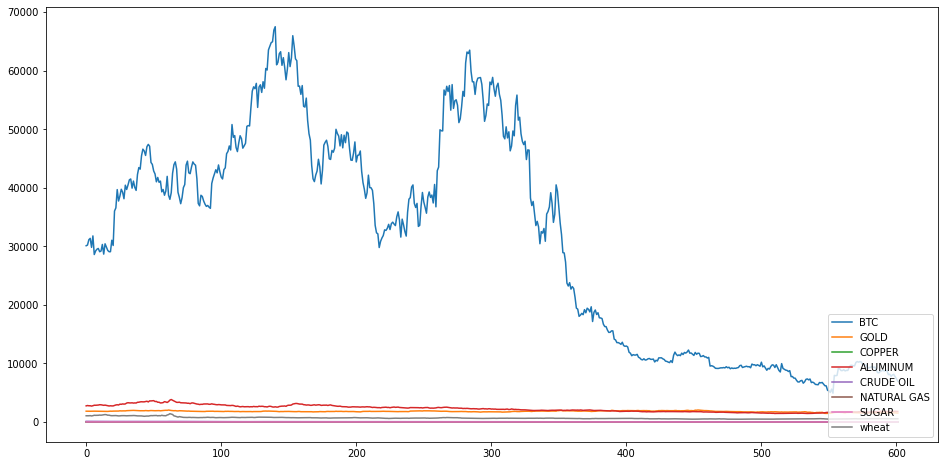

In [544]:
plt.figure(figsize = (16, 8))
plt.plot(main_df.btc, label = "BTC")
plt.plot(main_df.gold, label = "GOLD")
plt.plot(main_df.copper, label = "COPPER")
plt.plot(main_df.aluminum, label = "ALUMINUM")
plt.plot(main_df['crude-oil'], label = 'CRUDE OIL')
plt.plot(main_df['natural-gas'], label = "NATURAL GAS")
plt.plot(main_df['sugar'], label  = 'SUGAR')
plt.plot(main_df['wheat'], label = 'wheat')
plt.legend(loc = 'lower right')
plt.plot()

main_df

In [545]:
main_df = main_df.reset_index(drop = True)

In [546]:
#scale the data
outs = main_df[['btc']]
scalerinpts = preprocessing.MinMaxScaler()
scalerouts = preprocessing.MinMaxScaler()
main_df.iloc[:, 1:]= scalerinpts.fit_transform(main_df.iloc[:, 1:])
scalerouts.fit(outs)

MinMaxScaler()

In [547]:
X = main_df[['aluminum', 'btc', 'copper', 'crude-oil', 'gold', 'natural-gas', 'sugar', 'wheat']]
Y = main_df['btc']

In [548]:
def preprocessing_dataframe(dataframeX, dataframeY, window = 5):
    X = []
    Y = []
    for i in range(len(dataframeX) - window - 1):
        a = dataframeX.iloc[i:(i+window)]
        X.append(a)
        Y.append(dataframeY.iloc[i + window])
    return np.array(X), np.array(Y)

In [549]:
split = 0.75
length = int(len(X)*split)

trainX, trainY = X[0:length], Y[0:length]
testX, testY  = X[length:], Y[length: ]

In [550]:
trainX

,aluminum,btc,copper,crude-oil,gold,natural-gas,sugar,wheat
0,0.143486,0.032946,0.258194,0.203632,0.087047,0.081633,0.349688,0.090670
1,0.151655,0.038986,0.244355,0.202604,0.129183,0.082653,0.365745,0.084625
2,0.155425,0.045223,0.245084,0.204089,0.157621,0.083291,0.403211,0.079895
3,0.148303,0.051486,0.247269,0.207286,0.167158,0.086735,0.390723,0.080158
4,0.141600,0.049678,0.252549,0.195066,0.142709,0.084056,0.380018,0.082786
...,...,...,...,...,...,...,...,...
446,0.714495,0.912267,0.893846,0.472019,0.511184,0.447321,0.904550,0.275690
447,0.691244,0.947459,0.888383,0.476359,0.519681,0.459949,0.861731,0.275427
448,0.673439,0.975431,0.900583,0.485610,0.543957,0.470408,0.870651,0.289356
449,0.606829,0.914919,0.839221,0.468821,0.539102,0.463393,0.867975,0.280946


In [551]:
print(len(trainX), len(trainY))
print(trainX.iloc[1])

451 451
aluminum       0.151655
btc            0.038986
copper         0.244355
crude-oil      0.202604
gold           0.129183
natural-gas    0.082653
sugar          0.365745
wheat          0.084625
Name: 1, dtype: float64


In [552]:
trainX, trainY = preprocessing_dataframe(trainX, trainY, 7)
testX, testY = preprocessing_dataframe(testX, testY, 7)

In [553]:
np.shape(trainX)

(443, 7, 8)

In [554]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences = True, input_shape = (7, 8)),
    tf.keras.layers.LSTM(50, return_sequences = True),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

In [555]:
model.compile(loss = 'mse', optimizer = 'adam')

In [556]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 7, 50)             11800     
                                                                 
 lstm_40 (LSTM)              (None, 7, 50)             20200     
                                                                 
 lstm_41 (LSTM)              (None, 50)                20200     
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 52,251
Trainable params: 52,251
Non-trainable params: 0
_________________________________________________________________


In [557]:
history = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = 500, batch_size = 50, verbose = 1, callbacks = [tf.keras.callbacks.EarlyStopping(patience = 50)])

Epoch 1/500
9/9 [==============================] - 4s 172ms/step - loss: 0.1053 - val_loss: 0.0485
Epoch 2/500
9/9 [==============================] - 0s 9ms/step - loss: 0.0386 - val_loss: 0.0189
Epoch 3/500
9/9 [==============================] - 0s 9ms/step - loss: 0.0227 - val_loss: 0.0244
Epoch 4/500
9/9 [==============================] - 0s 9ms/step - loss: 0.0126 - val_loss: 0.0286
Epoch 5/500
9/9 [==============================] - 0s 8ms/step - loss: 0.0083 - val_loss: 0.0234
Epoch 6/500
9/9 [==============================] - 0s 8ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 7/500
9/9 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 8/500
9/9 [==============================] - 0s 9ms/step - loss: 0.0041 - val_loss: 0.0053
Epoch 9/500
9/9 [==============================] - 0s 9ms/step - loss: 0.0037 - val_loss: 0.0061
Epoch 10/500
9/9 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0063
Epoch 11/500
9/9 [=========

In [558]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

In [560]:
actualtrain = scalerouts.inverse_transform(trainY.reshape(-1, 1))
actualtest = scalerouts.inverse_transform(testY.reshape(-1,1))

In [561]:
train_predict = scalerouts.inverse_transform(train_predict)
test_predict = scalerouts.inverse_transform(test_predict)

In [563]:
print(train_predict)
print("*"*5000)
print(actualtrain)

[[ 9056.604 ]
 [ 9223.144 ]
 [ 9434.874 ]
 [ 9696.647 ]
 [ 9823.567 ]
 [ 9901.697 ]
 [10008.981 ]
 [10017.439 ]
 [ 9974.913 ]
 [ 9719.66  ]
 [ 9462.339 ]
 [ 9269.442 ]
 [ 9098.143 ]
 [ 9105.4795]
 [ 9191.487 ]
 [ 9331.309 ]
 [ 9473.583 ]
 [ 9504.147 ]
 [ 9493.43  ]
 [ 9557.147 ]
 [ 9625.601 ]
 [ 9741.214 ]
 [ 9921.795 ]
 [10036.259 ]
 [10050.598 ]
 [10038.711 ]
 [10013.179 ]
 [ 9992.186 ]
 [ 9928.919 ]
 [ 9835.744 ]
 [ 9631.498 ]
 [ 9306.55  ]
 [ 8887.068 ]
 [ 8704.345 ]
 [ 8548.626 ]
 [ 8444.969 ]
 [ 8354.876 ]
 [ 8295.02  ]
 [ 8296.818 ]
 [ 8230.557 ]
 [ 8257.747 ]
 [ 8145.6187]
 [ 8033.5137]
 [ 7859.7236]
 [ 7607.117 ]
 [ 7187.913 ]
 [ 6824.932 ]
 [ 6354.4175]
 [ 5834.317 ]
 [ 5951.7974]
 [ 5888.3447]
 [ 5957.659 ]
 [ 6047.1396]
 [ 6224.7856]
 [ 6151.435 ]
 [ 6190.5303]
 [ 6270.7266]
 [ 6279.3306]
 [ 6311.81  ]
 [ 6397.7104]
 [ 6635.422 ]
 [ 6843.509 ]
 [ 7009.2764]
 [ 7103.7393]
 [ 7216.087 ]
 [ 7319.264 ]
 [ 7243.789 ]
 [ 7141.0234]
 [ 7042.426 ]
 [ 7027.7104]
 [ 7128.293 ]
 [ 737

In [568]:
mean_squared_error(actualtrain, train_predict)

7057958.885560833